[GraphFrames in Jupyter: a practical guide](https://towardsdatascience.com/graphframes-in-jupyter-a-practical-guide-9b3b346cebc5)

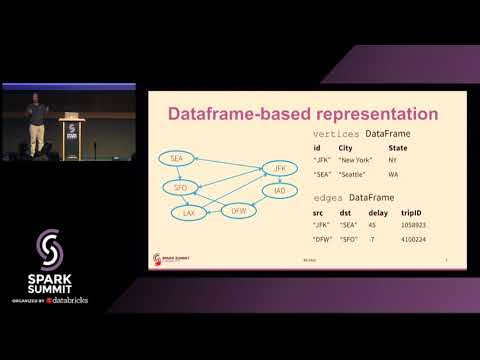

In [1]:
# https://youtu.be/NmbKst7ny5Q
# https://youtu.be/_mD1E33VmIg

from IPython.display import YouTubeVideo
YouTubeVideo('NmbKst7ny5Q')

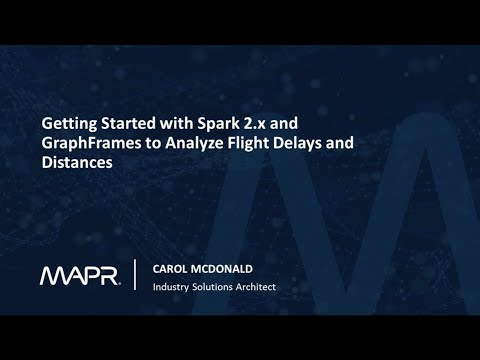

In [2]:
YouTubeVideo('_mD1E33VmIg')

In [3]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *

spark = SparkSession\
    .builder\
    .appName("chapter-30-graph")\
    .getOrCreate()

import os
SPARK_BOOK_DATA_PATH = os.environ['SPARK_BOOK_DATA_PATH']

In [4]:
bikeStations = spark.read\
  .option("header","true")\
  .csv(SPARK_BOOK_DATA_PATH + "/data/bike-data/201508_station_data.csv")

In [5]:
bikeStations.count()

70

In [6]:
bikeStations.show(3, False)

+----------+---------------------------------+---------+-----------+---------+--------+------------+
|station_id|name                             |lat      |long       |dockcount|landmark|installation|
+----------+---------------------------------+---------+-----------+---------+--------+------------+
|2         |San Jose Diridon Caltrain Station|37.329732|-121.901782|27       |San Jose|8/6/2013    |
|3         |San Jose Civic Center            |37.330698|-121.888979|15       |San Jose|8/5/2013    |
|4         |Santa Clara at Almaden           |37.333988|-121.894902|11       |San Jose|8/6/2013    |
+----------+---------------------------------+---------+-----------+---------+--------+------------+
only showing top 3 rows



In [7]:
tripData = spark.read\
  .option("header","true")\
  .csv(SPARK_BOOK_DATA_PATH + "/data/bike-data/201508_trip_data.csv")

In [8]:
tripData.count()

354152

In [9]:
tripData.show(3, False)

+-------+--------+---------------+------------------------------------+--------------+---------------+----------------------------------------+------------+------+---------------+--------+
|Trip ID|Duration|Start Date     |Start Station                       |Start Terminal|End Date       |End Station                             |End Terminal|Bike #|Subscriber Type|Zip Code|
+-------+--------+---------------+------------------------------------+--------------+---------------+----------------------------------------+------------+------+---------------+--------+
|913460 |765     |8/31/2015 23:26|Harry Bridges Plaza (Ferry Building)|50            |8/31/2015 23:39|San Francisco Caltrain (Townsend at 4th)|70          |288   |Subscriber     |2139    |
|913459 |1036    |8/31/2015 23:11|San Antonio Shopping Center         |31            |8/31/2015 23:28|Mountain View City Hall                 |27          |35    |Subscriber     |95032   |
|913455 |307     |8/31/2015 23:13|Post at Kearny       

In [10]:
# display dataframe in a pretty table
tripData.limit(5).toPandas()

,Trip ID,Duration,Start Date,Start Station,Start Terminal,End Date,End Station,End Terminal,Bike #,Subscriber Type,Zip Code
0,913460,765,8/31/2015 23:26,Harry Bridges Plaza (Ferry Building),50,8/31/2015 23:39,San Francisco Caltrain (Townsend at 4th),70,288,Subscriber,2139
1,913459,1036,8/31/2015 23:11,San Antonio Shopping Center,31,8/31/2015 23:28,Mountain View City Hall,27,35,Subscriber,95032
2,913455,307,8/31/2015 23:13,Post at Kearny,47,8/31/2015 23:18,2nd at South Park,64,468,Subscriber,94107
3,913454,409,8/31/2015 23:10,San Jose City Hall,10,8/31/2015 23:17,San Salvador at 1st,8,68,Subscriber,95113
4,913453,789,8/31/2015 23:09,Embarcadero at Folsom,51,8/31/2015 23:22,Embarcadero at Sansome,60,487,Customer,9069


In [11]:
# COMMAND ----------

stationVertices = bikeStations.withColumnRenamed("name", "id").distinct()

In [12]:
stationVertices.show(3, truncate=False)

+----------+-----------------------+---------+-----------+---------+-------------+------------+
|station_id|id                     |lat      |long       |dockcount|landmark     |installation|
+----------+-----------------------+---------+-----------+---------+-------------+------------+
|51        |Embarcadero at Folsom  |37.791464|-122.391034|19       |San Francisco|8/20/2013   |
|58        |San Francisco City Hall|37.77865 |-122.418235|19       |San Francisco|8/21/2013   |
|60        |Embarcadero at Sansome |37.80477 |-122.403234|15       |San Francisco|8/21/2013   |
+----------+-----------------------+---------+-----------+---------+-------------+------------+
only showing top 3 rows



In [13]:
tripEdges = tripData\
  .withColumnRenamed("Start Station", "src")\
  .withColumnRenamed("End Station", "dst")

In [14]:
tripEdges.limit(5).toPandas()
# tripEdges.show(3)

,Trip ID,Duration,Start Date,src,Start Terminal,End Date,dst,End Terminal,Bike #,Subscriber Type,Zip Code
0,913460,765,8/31/2015 23:26,Harry Bridges Plaza (Ferry Building),50,8/31/2015 23:39,San Francisco Caltrain (Townsend at 4th),70,288,Subscriber,2139
1,913459,1036,8/31/2015 23:11,San Antonio Shopping Center,31,8/31/2015 23:28,Mountain View City Hall,27,35,Subscriber,95032
2,913455,307,8/31/2015 23:13,Post at Kearny,47,8/31/2015 23:18,2nd at South Park,64,468,Subscriber,94107
3,913454,409,8/31/2015 23:10,San Jose City Hall,10,8/31/2015 23:17,San Salvador at 1st,8,68,Subscriber,95113
4,913453,789,8/31/2015 23:09,Embarcadero at Folsom,51,8/31/2015 23:22,Embarcadero at Sansome,60,487,Customer,9069


## GraphFrame

install **graphframes** pkg from https://spark-packages.org/package/graphframes/graphframes

download graphframes-0.7.0-spark2.4-s_2.11.jar and copy it to `~/spark/jars` folder

Re-start jupyter notebook
```
$ PYSPARK_DRIVER_PYTHON="jupyter" PYSPARK_DRIVER_PYTHON_OPTS="notebook" pyspark --packages graphframes:graphframes:0.7.0-spark2.4-s_2.11
```

In [15]:
# COMMAND ----------

from graphframes import GraphFrame

In [16]:
stationGraph = GraphFrame(stationVertices, tripEdges)
stationGraph.cache()

GraphFrame(v:[id: string, station_id: string ... 5 more fields], e:[src: string, dst: string ... 9 more fields])

In [17]:
# COMMAND ----------

print ("Total Number of Trips in Original Data: " + str(tripData.count()))
print ("Total Number of Stations: " + str(stationGraph.vertices.count()))
print ("Total Number of Trips in Graph: " + str(stationGraph.edges.count()))

Total Number of Trips in Original Data: 354152
Total Number of Stations: 70
Total Number of Trips in Graph: 354152


In [18]:
# COMMAND ----------

from pyspark.sql.functions import desc
stationGraph.edges.groupBy("src", "dst").count().orderBy(desc("count")).show(10,False)

+---------------------------------------------+----------------------------------------+-----+
|src                                          |dst                                     |count|
+---------------------------------------------+----------------------------------------+-----+
|San Francisco Caltrain 2 (330 Townsend)      |Townsend at 7th                         |3748 |
|Harry Bridges Plaza (Ferry Building)         |Embarcadero at Sansome                  |3145 |
|2nd at Townsend                              |Harry Bridges Plaza (Ferry Building)    |2973 |
|Townsend at 7th                              |San Francisco Caltrain 2 (330 Townsend) |2734 |
|Harry Bridges Plaza (Ferry Building)         |2nd at Townsend                         |2640 |
|Embarcadero at Folsom                        |San Francisco Caltrain (Townsend at 4th)|2439 |
|Steuart at Market                            |2nd at Townsend                         |2356 |
|Embarcadero at Sansome                       |Ste

In [19]:
# COMMAND ----------

stationGraph.edges\
  .where("src = 'Townsend at 7th' OR dst = 'Townsend at 7th'")\
  .groupBy("src", "dst").count()\
  .orderBy(desc("count"))\
  .show(10,False)

+---------------------------------------------+---------------------------------------------+-----+
|src                                          |dst                                          |count|
+---------------------------------------------+---------------------------------------------+-----+
|San Francisco Caltrain 2 (330 Townsend)      |Townsend at 7th                              |3748 |
|Townsend at 7th                              |San Francisco Caltrain 2 (330 Townsend)      |2734 |
|Townsend at 7th                              |San Francisco Caltrain (Townsend at 4th)     |2192 |
|Townsend at 7th                              |Civic Center BART (7th at Market)            |1844 |
|Civic Center BART (7th at Market)            |Townsend at 7th                              |1765 |
|San Francisco Caltrain (Townsend at 4th)     |Townsend at 7th                              |1198 |
|Temporary Transbay Terminal (Howard at Beale)|Townsend at 7th                              |834  |


### subgraph

In [20]:
# COMMAND ----------

townAnd7thEdges = stationGraph.edges\
  .where("src = 'Townsend at 7th' OR dst = 'Townsend at 7th'")
subgraph = GraphFrame(stationGraph.vertices, townAnd7thEdges)

In [21]:
# COMMAND ----------
print("Connected to station= Townsend at 7th")
print ("Number of Stations: " + str(subgraph.vertices.count()))
print ("Number of Trips in Graph: " + str(subgraph.edges.count()))

Connected to station= Townsend at 7th
Number of Stations: 70
Number of Trips in Graph: 28999


### motif

In [23]:
# COMMAND ----------

motifs = stationGraph.find("(a)-[ab]->(b); (b)-[bc]->(c); (c)-[ca]->(a)")

In [37]:
# COMMAND ----------

from pyspark.sql.functions import expr
abcTrip = motifs.selectExpr("*",
    "to_timestamp(ab.`Start Date`, 'MM/dd/yyyy HH:mm') as abStart",
    "to_timestamp(bc.`Start Date`, 'MM/dd/yyyy HH:mm') as bcStart",
    "to_timestamp(ca.`Start Date`, 'MM/dd/yyyy HH:mm') as caStart")\
  .where("ca.`Bike #` = bc.`Bike #`")\
  .where("ab.`Bike #` = bc.`Bike #`")\
  .where("a.id != b.id")\
  .where("b.id != c.id")\
  .where("abStart < bcStart")\
  .where("bcStart < caStart")\
  .orderBy(expr("cast(caStart as long) - cast(abStart as long)"))\
  .selectExpr("a.id as Id_a", 
              "b.id as Id_b", 
              "c.id as Id_c", 
              "ab.`Start Date` as Start_ab", 
              "bc.`Start Date` as Start_bc", 
              "ca.`Start Date` as Start_ca", 
              "ca.`End Date` as End_ca")\
  .limit(5)
#  .show(truncate=False)

In [38]:
abcTrip.toPandas()

,Id_a,Id_b,Id_c,Start_ab,Start_bc,Start_ca,End_ca
0,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,San Francisco Caltrain (Townsend at 4th),5/19/2015 16:09,5/19/2015 16:14,5/19/2015 16:18,5/19/2015 16:33
1,Harry Bridges Plaza (Ferry Building),2nd at Townsend,San Francisco Caltrain (Townsend at 4th),6/16/2015 8:03,6/16/2015 8:12,6/16/2015 8:17,6/16/2015 8:31
2,2nd at Townsend,San Francisco Caltrain (Townsend at 4th),Harry Bridges Plaza (Ferry Building),7/20/2015 8:51,7/20/2015 8:55,7/20/2015 9:06,7/20/2015 9:14
3,Market at Sansome,2nd at South Park,San Francisco Caltrain (Townsend at 4th),11/3/2014 8:38,11/3/2014 8:46,11/3/2014 8:53,11/3/2014 9:01
4,San Francisco Caltrain (Townsend at 4th),2nd at Townsend,Steuart at Market,10/8/2014 17:12,10/8/2014 17:19,10/8/2014 17:27,10/8/2014 17:42


### pageRank

In [39]:
# COMMAND ----------

from pyspark.sql.functions import desc
ranks = stationGraph.pageRank(resetProbability=0.15, maxIter=10)
ranks.vertices\
    .orderBy(desc("pagerank"))\
    .select("id", "pagerank")\
    .show(10, False)

+----------------------------------------+------------------+
|id                                      |pagerank          |
+----------------------------------------+------------------+
|San Jose Diridon Caltrain Station       |4.051504835990019 |
|San Francisco Caltrain (Townsend at 4th)|3.3511832964286965|
|Mountain View Caltrain Station          |2.5143907710155435|
|Redwood City Caltrain Station           |2.326308771371171 |
|San Francisco Caltrain 2 (330 Townsend) |2.231144291369883 |
|Harry Bridges Plaza (Ferry Building)    |1.8251120118882473|
|2nd at Townsend                         |1.5821217785038688|
|Santa Clara at Almaden                  |1.5730074084907584|
|Townsend at 7th                         |1.5684565805340545|
|Embarcadero at Sansome                  |1.5414242087748589|
+----------------------------------------+------------------+
only showing top 10 rows



### inDegrees

In [40]:
# COMMAND ----------

inDeg = stationGraph.inDegrees
inDeg.orderBy(desc("inDegree")).show(5, False)

+----------------------------------------+--------+
|id                                      |inDegree|
+----------------------------------------+--------+
|San Francisco Caltrain (Townsend at 4th)|34810   |
|San Francisco Caltrain 2 (330 Townsend) |22523   |
|Harry Bridges Plaza (Ferry Building)    |17810   |
|2nd at Townsend                         |15463   |
|Townsend at 7th                         |15422   |
+----------------------------------------+--------+
only showing top 5 rows



### outDegrees

In [41]:
# COMMAND ----------

outDeg = stationGraph.outDegrees
outDeg.orderBy(desc("outDegree")).show(5, False)

+---------------------------------------------+---------+
|id                                           |outDegree|
+---------------------------------------------+---------+
|San Francisco Caltrain (Townsend at 4th)     |26304    |
|San Francisco Caltrain 2 (330 Townsend)      |21758    |
|Harry Bridges Plaza (Ferry Building)         |17255    |
|Temporary Transbay Terminal (Howard at Beale)|14436    |
|Embarcadero at Sansome                       |14158    |
+---------------------------------------------+---------+
only showing top 5 rows



In [42]:
# COMMAND ----------

degreeRatio = inDeg.join(outDeg, "id")\
  .selectExpr("id", "double(inDegree)/double(outDegree) as degreeRatio")

In [43]:
# top 10
degreeRatio.orderBy(desc("degreeRatio")).show(10, False)

+----------------------------------------+------------------+
|id                                      |degreeRatio       |
+----------------------------------------+------------------+
|Redwood City Medical Center             |1.5333333333333334|
|San Mateo County Center                 |1.4724409448818898|
|SJSU 4th at San Carlos                  |1.3621052631578947|
|San Francisco Caltrain (Townsend at 4th)|1.3233728710462287|
|Washington at Kearny                    |1.3086466165413533|
|Paseo de San Antonio                    |1.2535046728971964|
|California Ave Caltrain Station         |1.24              |
|Franklin at Maple                       |1.2345679012345678|
|Embarcadero at Vallejo                  |1.2201707365495336|
|Market at Sansome                       |1.2173913043478262|
+----------------------------------------+------------------+
only showing top 10 rows



In [44]:
# bottom 10
degreeRatio.orderBy("degreeRatio").show(10, False)

+-------------------------------+------------------+
|id                             |degreeRatio       |
+-------------------------------+------------------+
|Grant Avenue at Columbus Avenue|0.5180520570948782|
|2nd at Folsom                  |0.5909488686085761|
|Powell at Post (Union Square)  |0.6434241245136186|
|Mezes Park                     |0.6839622641509434|
|Evelyn Park and Ride           |0.7413087934560327|
|Beale at Market                |0.75726761574351  |
|Golden Gate at Polk            |0.7822270981897971|
|Ryland Park                    |0.7857142857142857|
|San Francisco City Hall        |0.7928849902534113|
|Palo Alto Caltrain Station     |0.8064516129032258|
+-------------------------------+------------------+
only showing top 10 rows



### BFS

In [48]:
# COMMAND ----------

stationGraph.bfs(fromExpr="id = 'Townsend at 7th'",
  toExpr="id = 'Spear at Folsom'", maxPathLength=2).show(1,False)



+---------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------+
|from                                                                       |e0                                                                                                               |to                                                                         |
+---------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------+
|[65, Townsend at 7th, 37.771058, -122.402717, 15, San Francisco, 8/22/2013]|[913371, 663, 8/31/2015 20:10, Townsend at 7th, 65, 8/31/2015 20:21, Spear at Folsom, 49, 405, Subscriber, 94103]|[49, 

### connectedComponents

In [49]:
# COMMAND ----------

spark.sparkContext.setCheckpointDir("/tmp/checkpoints")

In [50]:
# COMMAND ----------

minGraph = GraphFrame(stationVertices, tripEdges.sample(False, 0.1))
cc = minGraph.connectedComponents()

In [51]:
# COMMAND ----------

cc.where("component != 0").show(5, False)

+----------+-------------------------------------+---------+-----------+---------+-------------+------------+----------+
|station_id|id                                   |lat      |long       |dockcount|landmark     |installation|component |
+----------+-------------------------------------+---------+-----------+---------+-------------+------------+----------+
|33        |Rengstorff Avenue / California Street|37.400241|-122.099076|15       |Mountain View|8/16/2013   |8589934592|
|25        |Stanford in Redwood City             |37.48537 |-122.203288|15       |Redwood City |8/12/2013   |8589934592|
|84        |Ryland Park                          |37.342725|-121.895617|15       |San Jose     |4/9/2014    |8589934592|
|12        |SJSU 4th at San Carlos               |37.332808|-121.883891|19       |San Jose     |8/7/2013    |8589934592|
|16        |SJSU - San Salvador at 9th           |37.333955|-121.877349|15       |San Jose     |8/7/2013    |8589934592|
+----------+--------------------

In [52]:
# COMMAND ----------

scc = minGraph.stronglyConnectedComponents(maxIter=3)

In [53]:
# COMMAND ----------

In [54]:
type(scc)

pyspark.sql.dataframe.DataFrame

In [55]:
scc.count()

70

In [56]:
scc.limit(10).toPandas()

,station_id,id,lat,long,dockcount,landmark,installation,component
0,11,MLK Library,37.335885,-121.88566,19,San Jose,8/6/2013,128849018880
1,80,Santa Clara County Civic Center,37.352601,-121.905733,15,San Jose,12/31/2013,128849018880
2,64,2nd at South Park,37.782259,-122.392738,15,San Francisco,8/22/2013,0
3,36,California Ave Caltrain Station,37.429082,-122.142805,15,Palo Alto,8/14/2013,8589934592
4,62,2nd at Folsom,37.785299,-122.396236,19,San Francisco,8/22/2013,0
5,5,Adobe on Almaden,37.331415,-121.8932,19,San Jose,8/5/2013,128849018880
6,75,Mechanics Plaza (Market at Battery),37.7913,-122.399051,19,San Francisco,8/25/2013,0
7,63,Howard at 2nd,37.786978,-122.398108,19,San Francisco,8/22/2013,0
8,83,Mezes Park,37.491269,-122.236234,15,Redwood City,2/20/2014,8589934592
9,42,Davis at Jackson,37.79728,-122.398436,15,San Francisco,8/19/2013,0
